# Přísnost známkování na TIMSS 2007

## Imports

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.

  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [2]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

## Stata data loading

In [22]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/idea/data"

// load students data
use ${PATHD}/TIMSS/2007/CZ/czt07_zak8.dta, clear

gen gr_matematika = bs4nznma
recode gr_matematika 0 8 9=.
egen gr_matematika_z = std(gr_matematika)

recode itsex 1=1 2=0, gen(girl)

// multiple imputations to handle plausible values
gen math=1/0
mi import wide, imputed(math=bsmmat0*) clear

mi passive: egen mathz = std(math)

drop if missing(gr_matematika)
// dropni víceletá gymnázia
drop if typ==2 

// jak fungují váhy?
gen wgt1 = wgtadj1 * wgtfac1
gen wgt2 = wgtadj2 * wgtfac2
gen wgt3 = wgtadj3 * wgtfac3

gen wgt12 = wgt1 * wgt2

// jen na ověření, zdali mi to skutečně dá totwgt -> ano, dá
gen wgt123 = wgt1 * wgt2 * wgt3

recode bsnghfsg 6 7=1 1 2 3 4 5=0 8 99=., gen(chcevs)

In [54]:
%stata count

  4,252


## Basic descriptives

In [27]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [28]:
df.shape

(4252, 429)

In [29]:
df.head()

,idcntry,idschool,idclass,idgrade,idstud,itbirthm,itbirthy,itsex,idbook,itadmini,...,_2_mathz,_3_mathz,_4_mathz,_5_mathz,wgt1,wgt2,wgt3,wgt12,wgt123,chcevs
0,203,19,1901,8,190101,8,1992,1,14,3,...,-1.078231,-1.390152,-1.106371,-0.506067,18.416668,1.0,1.066667,18.416668,19.644447,0.0
1,203,19,1901,8,190102,4,1993,1,1,3,...,-1.123760,-1.029018,-1.457708,-1.250027,18.416668,1.0,1.066667,18.416668,19.644447,0.0
2,203,19,1901,8,190104,4,1993,2,3,3,...,-0.227627,-0.594207,-0.005250,-0.228219,18.416668,1.0,1.066667,18.416668,19.644447,0.0
3,203,19,1901,8,190105,12,1992,2,4,3,...,-0.040225,-0.387199,-0.345463,-0.366920,18.416668,1.0,1.066667,18.416668,19.644447,NaN
4,203,19,1901,8,190106,9,1992,2,5,3,...,1.900870,1.777818,1.999579,1.300544,18.416668,1.0,1.066667,18.416668,19.644447,1.0


### Lineplot

In [6]:
%stata mi estimate, dots: reg math ibn.gr_matematika [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.2536
                                                Largest FMI       =     0.2851
                                                Complete DF       =       4247
DF adjustment:   Small sample                   DF:     min       =      57.62
                                                        avg       =     192.73
                                                        max       =     546.14
Model F test:       Equal FMI                   F(   5,  309.9)   =   53606.21
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [8]:
er = stata.get_ereturn()
b_mi = er['e(b_mi)']
V_mi = er['e(V_mi)']
dfr = er['e(df_r_mi)']
coefs = b_mi[0]
std_errs = np.sqrt(np.diag(V_mi))

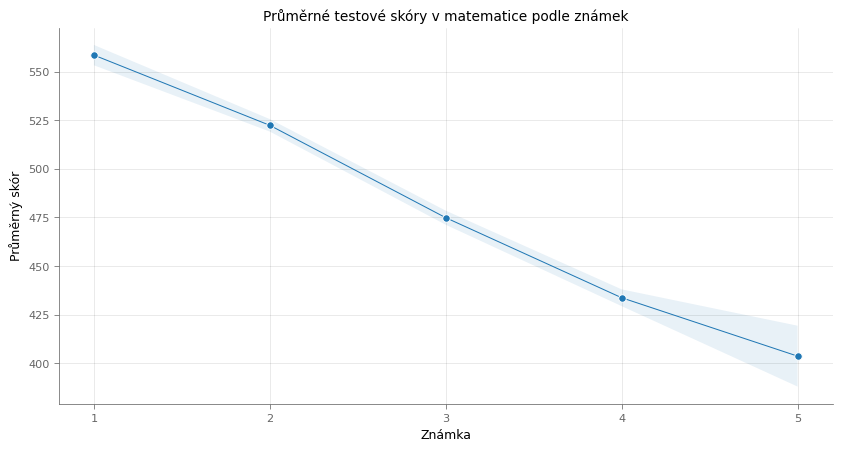

In [9]:
foo = pd.DataFrame({'grade': range(1, 6), 'coef': coefs, 'se': std_errs})

foo['lower'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['upper'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']

fig, ax = plt.subplots()
sns.lineplot(x='grade', y='coef', data=foo, marker='o')
plt.fill_between(foo['grade'], foo['lower'], foo['upper'], alpha=0.1)
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v matematice podle známek')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))

### Boxplots

In [10]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = totwgt]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 1





running 2





running 3





running 4





running 5







[Text(0.5, 1.0, 'Testové skóry v matematice podle známek'),
 Text(0.5, 0, 'Testový skór'),
 Text(0, 0.5, 'Známka')]

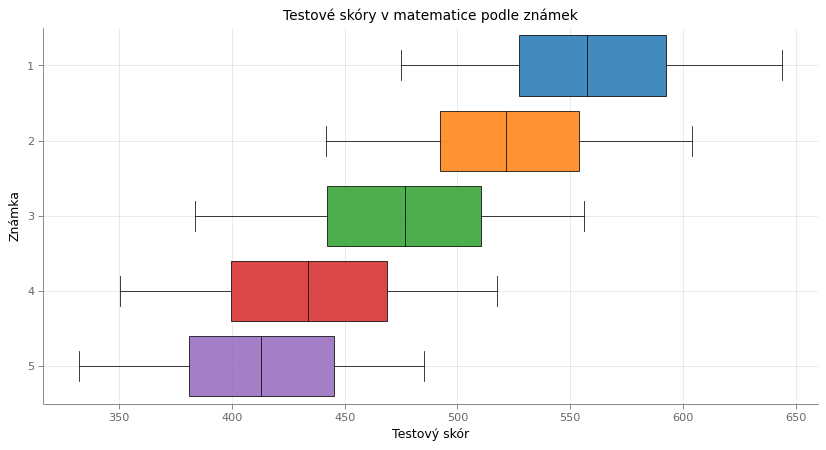

In [11]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=False, positions=range(6, 1, -1), widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='Testové skóry v matematice podle známek', xlabel='Testový skór', ylabel='Známka')

## Model a přísnost jednotlivých škol

In [23]:
%stata mi estimate, dots: mixed gr_matematika mathz girl [pw = wgt3] || idclass: , pweight (wgt12) pwscale(size)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      4,252

Group variable: idclass                         Number of groups  =        197
                                                Obs per group:
                                                              min =         11
                                                              avg =       21.6
                                                              max =         30
                                                Average RVI       =     0.0336
                                                Largest FMI       =     0.0631
DF adjustment:   Large sample                   DF:     min       =   1,063.18
                                                        avg       =  14,261.20
                                                        max       =  37,270.12
Model F test:       Equal FMI      

In [24]:
coefs = stata.get_ereturn()['e(b_mi)'][0]

In [25]:
coefs

array([-0.77465049, -0.27066367,  2.58734554, -1.26766505, -0.35092079])

In [30]:
for i in range(1,6):
    df[f'bsmmat0{i}z'] = (df[f'bsmmat0{i}'] - df[f'bsmmat0{i}'].mean()) / df[f'bsmmat0{i}'].std()
    
df['MATH_MEAN'] = np.mean(df[[f'bsmmat0{i}' for i in range(1,6)]], axis=1)
df['MATH_Z'] = np.mean(df[[f'bsmmat0{i}z' for i in range(1,6)]], axis=1)

In [31]:
df['gr_matematika_pred'] = coefs[2] + coefs[1] * df['girl'] + coefs[0] * df['MATH_Z']
df['gr_matematika_resid'] = df['gr_matematika'] - df['gr_matematika_pred']

In [32]:
n_bins = 4

# ať to můžu pouštět opakovaně
df = df.drop(columns=['prisnost', 'prisnost_bin'], errors='ignore')

sch_resid = df.groupby('idclass')[['gr_matematika_resid', 'wgt12', 'wgt3']]\
    .apply(nanaverage, weights='wgt3')\
    .rename(columns={'gr_matematika_resid': 'prisnost'})\
    .reset_index()

dsw = DescrStatsW(sch_resid['prisnost'], weights=sch_resid['wgt12'])
qs = dsw.quantile(np.arange(1, n_bins) / n_bins)
sch_resid['prisnost_bin'] = pd.cut(sch_resid['prisnost'], [-np.inf] + list(qs) + [np.inf], labels=False)

# hack to flatten the middle two --> this is the best I think - přísné, shovívavé, neutrální
sch_resid['prisnost_bin'] = np.round(2 * sch_resid['prisnost_bin'] / 3)

df = pd.merge(df, sch_resid.drop(columns=['wgt12']))

### Přísnost do Staty

In [33]:
stata.pdataframe_to_frame(sch_resid.drop(columns=['wgt12']), 'classes')

In [34]:
%%stata
frame dir
frlink m:1 idclass, frame(classes idclass)
frget(prisnost prisnost_bin), from(classes)
tab prisnost_bin


. frame dir
* classes  197 x 3
* default  4252 x 429; czt07_zak8.dta

Note: Frames marked with * contain unsaved data.

. frlink m:1 idclass, frame(classes idclass)
  (all observations in frame default matched)

. frget(prisnost prisnost_bin), from(classes)
  (2 variables copied from linked frame)

. tab prisnost_bin

prisnost_bi |
          n |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        897       21.10       21.10
          1 |      2,187       51.43       72.53
          2 |      1,168       27.47      100.00
------------+-----------------------------------
      Total |      4,252      100.00

. 


### Charakteristiky skupin přísnosti

In [38]:
sch_resid['prisnost'].min(), sch_resid['prisnost'].max()

(-0.9228349413148055, 1.0311179478203225)

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[Text(0.5, 0, 'Přísnost známkování'),
 Text(0, 0.5, 'Vážená četnost'),
 Text(0.5, 1.0, 'Školy podle přísnosti')]

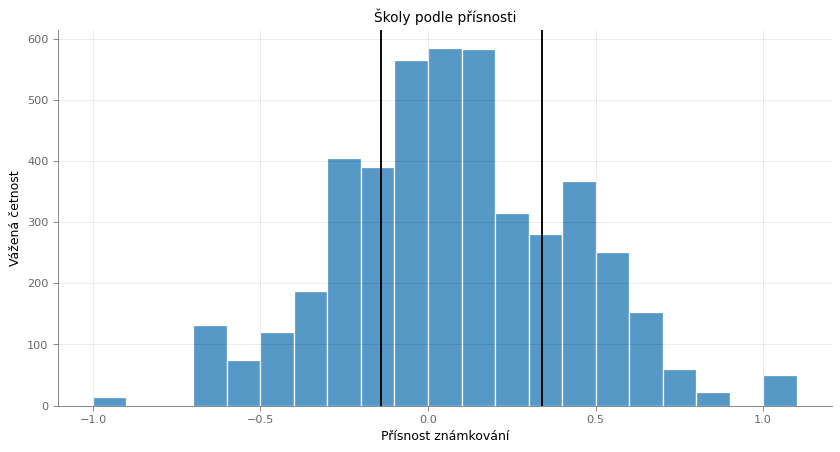

In [42]:
fig, ax = plt.subplots()
bins = np.arange(-1, 1.2, step=0.1)
sns.histplot(x='prisnost', weights='wgt12', data=sch_resid, bins=bins, edgecolor='white')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Vážená četnost', title='Školy podle přísnosti')

In [47]:
sch_resid.groupby('prisnost_bin')[['prisnost', 'wgt12']].apply(nanaverage, weights='wgt12')

,prisnost
prisnost_bin,
0.0,-0.332999
1.0,0.065112
2.0,0.531898


[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry z matematiky podle známek a přísnosti škol')]

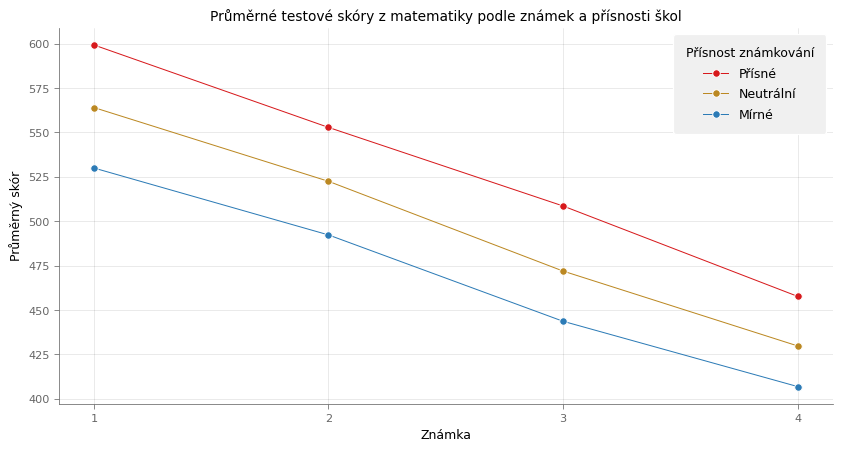

In [45]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

foo = df.groupby(['gr_matematika', 'prisnost_bin'])[['MATH_MEAN', 'chcevs', 'totwgt']].apply(nanaverage, weights='totwgt').reset_index()
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo = foo[foo['gr_matematika'] != 5]
foo['gr_matematika'] = foo['gr_matematika'].apply(lambda x: f'{x:.0g}')
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry z matematiky podle známek a přísnosti škol')

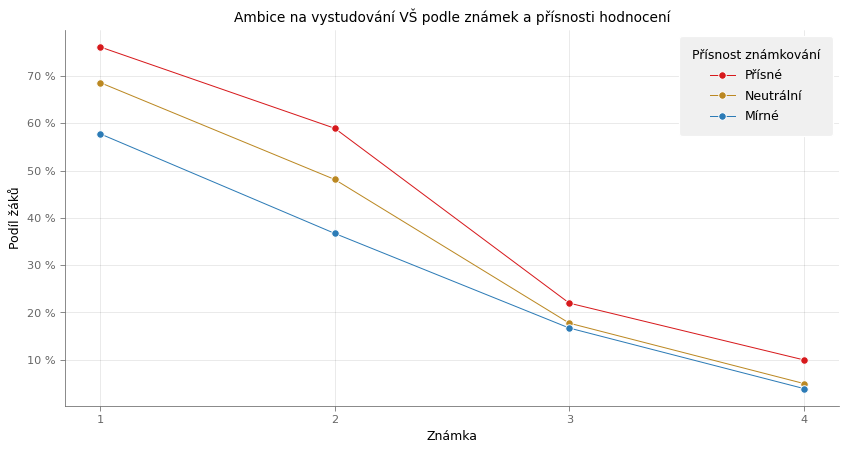

In [48]:
foo['chcevsx100'] = 100 * foo['chcevs']
ax = sns.lineplot(x='gr_matematika', y='chcevsx100', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Ambice na vystudování VŠ podle známek a přísnosti hodnocení', xlabel='Známka', ylabel='Podíl žáků')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

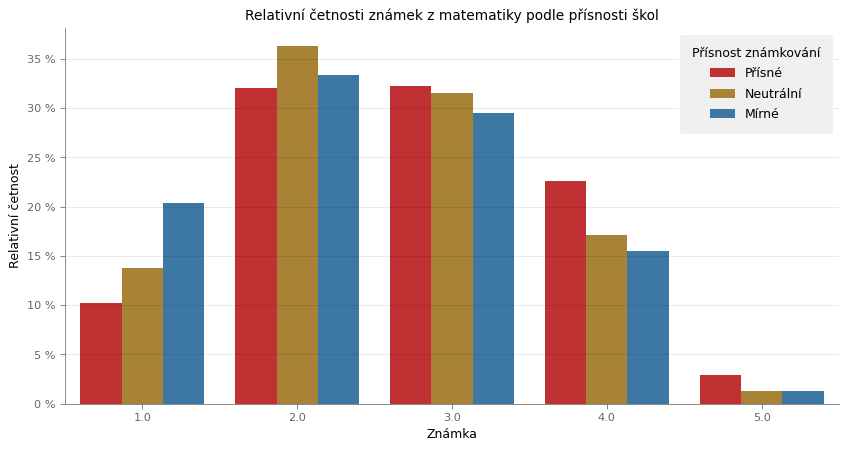

In [49]:
foo = df.groupby(['gr_matematika', 'prisnost_bin'])['totwgt'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('prisnost_bin')['totwgt'].sum().rename('totwgt_TOTAL').reset_index())
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo['rel_weight'] = 100 * foo['totwgt'] / foo['totwgt_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='prisnost_group', data=foo, palette=prisnost_pal, hue_order=prisnost_order)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set_title('Relativní četnosti známek z matematiky podle přísnosti škol')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

In [50]:
%stata mi estimate, dots: reg math ibn.prisnost_bin [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.1016
                                                Largest FMI       =     0.1905
                                                Complete DF       =       4249
DF adjustment:   Small sample                   DF:     min       =     122.17
                                                        avg       =   1,597.33
                                                        max       =   4,090.23
Model F test:       Equal FMI                   F(   3,  586.2)   =   61985.12
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [51]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

blbls = ['Mírné', 'Neutrální', 'Přísné']

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,517.556430,2.540154,512.576400,522.536459,2,Přísné
1,494.983376,1.514948,492.013286,497.953465,1,Neutrální
2,470.828832,2.398793,466.125945,475.531720,0,Mírné


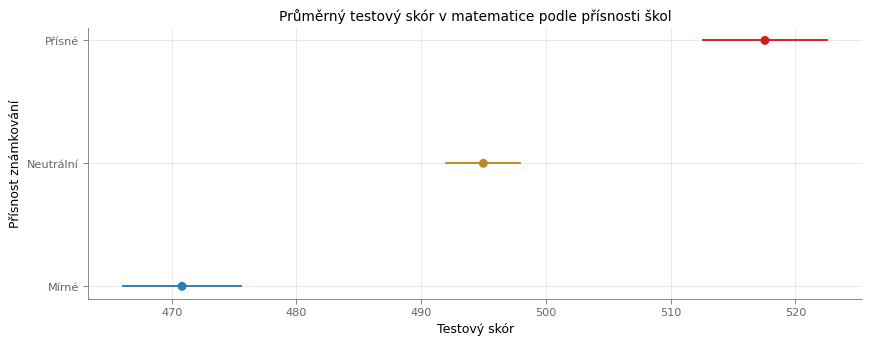

In [52]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Testový skór', ylabel='Přísnost známkování', title='Průměrný testový skór v matematice podle přísnosti škol')
None

In [53]:
%stata mi estimate, dots: logit chcevs gr_matematika_z mathz girl [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,805
                                                Average RVI       =     0.1651
                                                Largest FMI       =     0.4364
DF adjustment:   Large sample                   DF:     min       =      25.74
                                                        avg       =   3,353.90
                                                        max       =   7,571.63
Model F test:       Equal FMI                   F(   3,  188.9)   =     133.73
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z |  -.7